# Analisis de resultados.

**Nombre : Rommel Pacheco Hernández**

# ¿Que voy a hacer?

Voy a hacer un análisis usando el método de clustering para dividir al alumnado en grupos para saber su score dependiendo su lunch y su preparación para su examen.

# Subiendo datos

In [4]:
# Carga las librerías necesarias.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import plotly.express as px

In [5]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving StudentsPerformance.csv to StudentsPerformance.csv
User uploaded file "StudentsPerformance.csv" with length 72036 bytes


In [6]:
#leyendo datos
df = pd.read_csv('StudentsPerformance.csv')

#Limpiando datos.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   gender                       1000 non-null   object
 1   race/ethnicity               1000 non-null   object
 2   parental level of education  1000 non-null   object
 3   lunch                        1000 non-null   object
 4   test preparation course      1000 non-null   object
 5   math score                   1000 non-null   int64 
 6   reading score                1000 non-null   int64 
 7   writing score                1000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 62.6+ KB


Podemos observar que tenemos todos os datos y unicamente tenemos tres datos cuantitativos. Ahora escogeré las columnas que me parecen importantes.

In [8]:
df2 = df.drop(['gender','race/ethnicity'], axis=1)
df2

,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,bachelor's degree,standard,none,72,72,74
1,some college,standard,completed,69,90,88
2,master's degree,standard,none,90,95,93
3,associate's degree,free/reduced,none,47,57,44
4,some college,standard,none,76,78,75
...,...,...,...,...,...,...
995,master's degree,standard,completed,88,99,95
996,high school,free/reduced,none,62,55,55
997,high school,free/reduced,completed,59,71,65
998,some college,standard,completed,68,78,77


Ya preparados los datos vamos a empezar a usar estádisticas

#Usando estádistica

In [9]:
df2.max()

parental level of education    some high school
lunch                                  standard
test preparation course                    none
math score                                  100
reading score                               100
writing score                               100
dtype: object

In [10]:
df2.min()

parental level of education    associate's degree
lunch                                free/reduced
test preparation course                 completed
math score                                      0
reading score                                  17
writing score                                  10
dtype: object

In [11]:
df2.describe()

,math score,reading score,writing score
count,1000.00000,1000.000000,1000.000000
mean,66.08900,69.169000,68.054000
std,15.16308,14.600192,15.195657
min,0.00000,17.000000,10.000000
25%,57.00000,59.000000,57.750000
50%,66.00000,70.000000,69.000000
75%,77.00000,79.000000,79.000000
max,100.00000,100.000000,100.000000


Podemos ver que en el tercer quantil hay una mayor calificación.

In [12]:
df2.median()

<ipython-input-12-05e26ec02eba>:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df2.median()


math score       66.0
reading score    70.0
writing score    69.0
dtype: float64

En este ejercicio la correlación nos servirá para ver que tanto aumenta una variable junto a las otras.

In [13]:
dfcorr = df2.corr()
dfcorr

,math score,reading score,writing score
math score,1.000000,0.817580,0.802642
reading score,0.817580,1.000000,0.954598
writing score,0.802642,0.954598,1.000000


Vemos que (sin afirmar una relación causa y efecto) se impactan directamente a su aumento.

#Análisis Gráfico

Haré un Heat Map de correlación para verla de una mejor forma.

<Axes: >

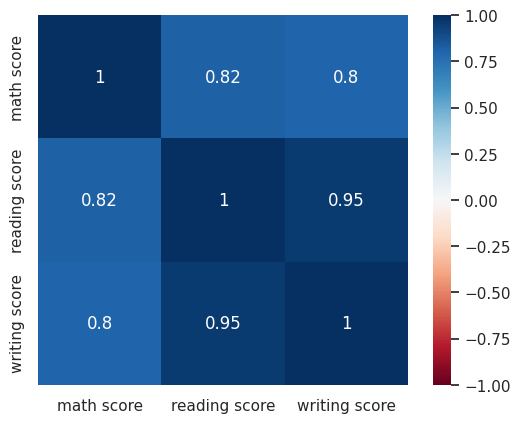

In [14]:

sns.heatmap(data=dfcorr, vmin=-1, vmax=1, cmap = 'RdBu', annot=True, square = True)

Haré un pairplot para ver datos extraños y ver si puedo dividir en grupos.

Text(0.5, 1.05, 'Gráfico de pares de las variables numéricas por lunch')

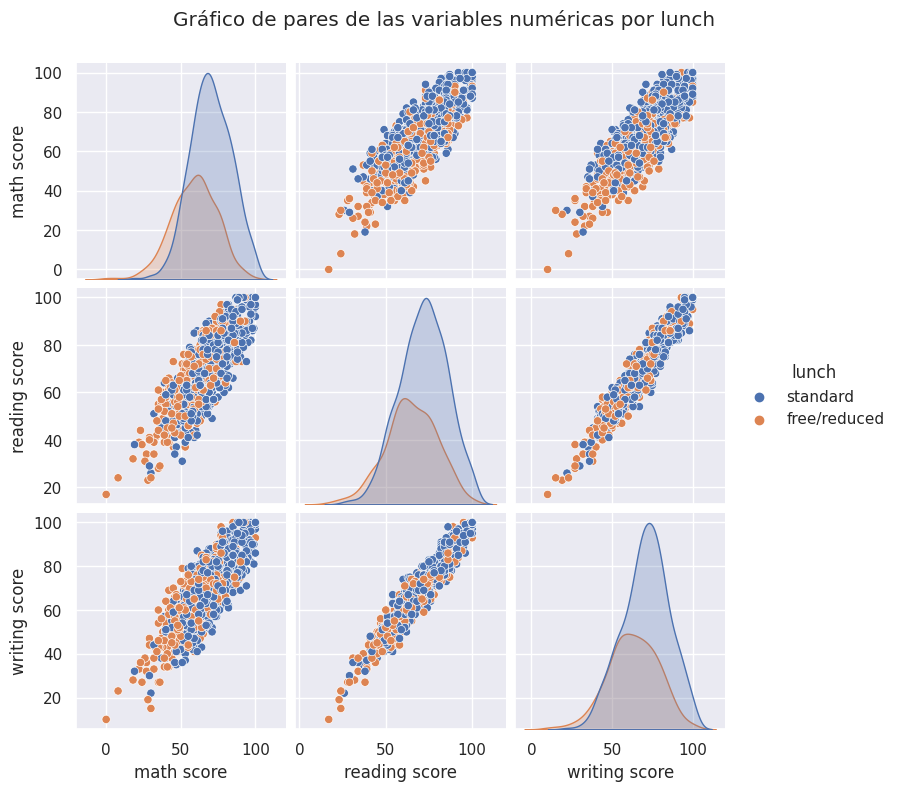

In [15]:
sns.pairplot(data = df2, hue='lunch')
plt.suptitle('Gráfico de pares de las variables numéricas por lunch', y=1.05)

Text(0.5, 1.05, 'Gráfico de pares de las variables numéricas por lunch')

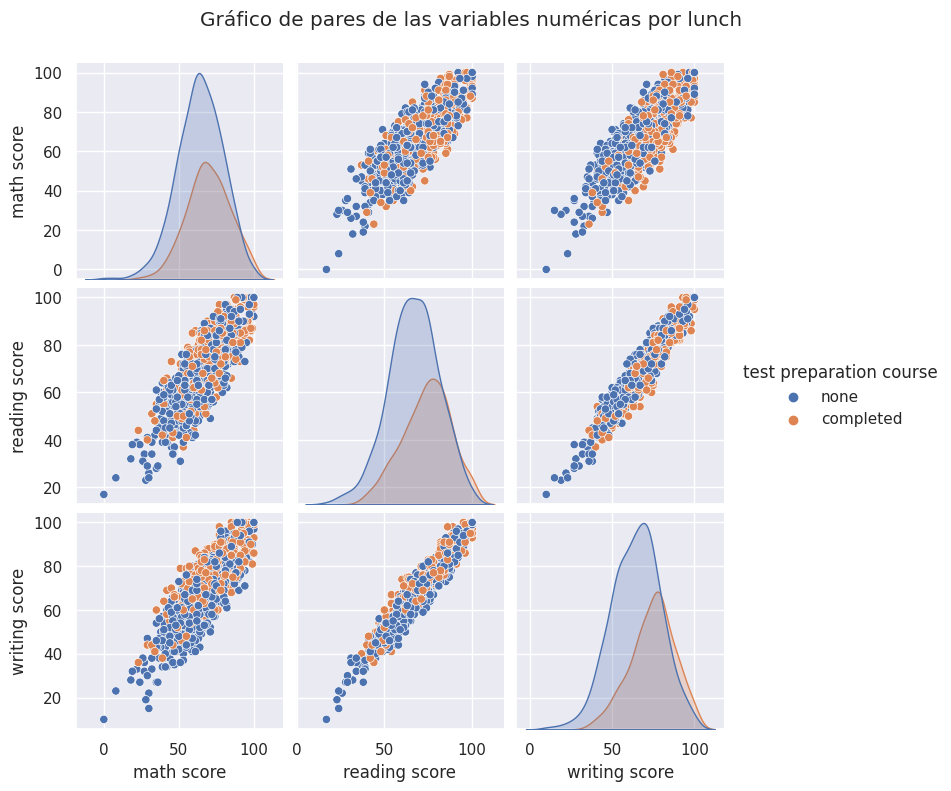

In [16]:
sns.pairplot(data = df2, hue='test preparation course')
plt.suptitle('Gráfico de pares de las variables numéricas por lunch', y=1.05)

Necesitaremos una gráfica 3D para poder distinguir mejor los grupos. Podemos ver que quienes completan una preparación para el examen tienen ligeramente una calificación más cercana a 100, mientras que los que tienen un lunch standard tiene un mayor impacto en su calificación.

No podremos usar una grafica de bigote para ver datos extraordinarios, pero podemos ver en el pairplot como solo existen unos pocos.

#Empezamos con el clustering

In [17]:
numeric_cols = ['reading score', 'math score',	'writing score']
X = df.loc[:, numeric_cols]

# Hacemos el escalamiento.
scaler = StandardScaler()
X_norm = scaler.fit_transform(X)

# El escalador nos genera una matriz de numpy. Vamos a convertirlo en DF
X_norm = pd.DataFrame(X_norm, columns=numeric_cols)
X_norm.head()

,reading score,math score,writing score
0,0.193999,0.390024,0.391492
1,1.427476,0.192076,1.313269
2,1.770109,1.577711,1.642475
3,-0.833899,-1.259543,-1.583744
4,0.605158,0.653954,0.457333


In [18]:
kmax   = 5
#Use 4 grupos porque son los suficientes para  determinar donde se hace una
# pendiente más grandes, si usaba más ya no eran necesarios 
grupos = range(2, kmax)
wcss   = []
sil_score = []

# Ciclo para calcular K-Means para diferentes k
for k in grupos:
    # Clustering
    model = KMeans(n_clusters=k, random_state = 47)

    # Obtener las etiquetas
    clusters = model.fit_predict(X_norm)

    # Guardar WCSS
    wcss.append(model.inertia_)

    # Guardar Silhouette Score
    sil_score.append(silhouette_score(X_norm, clusters))

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Text(0.5, 1.0, 'Silhouette Score')

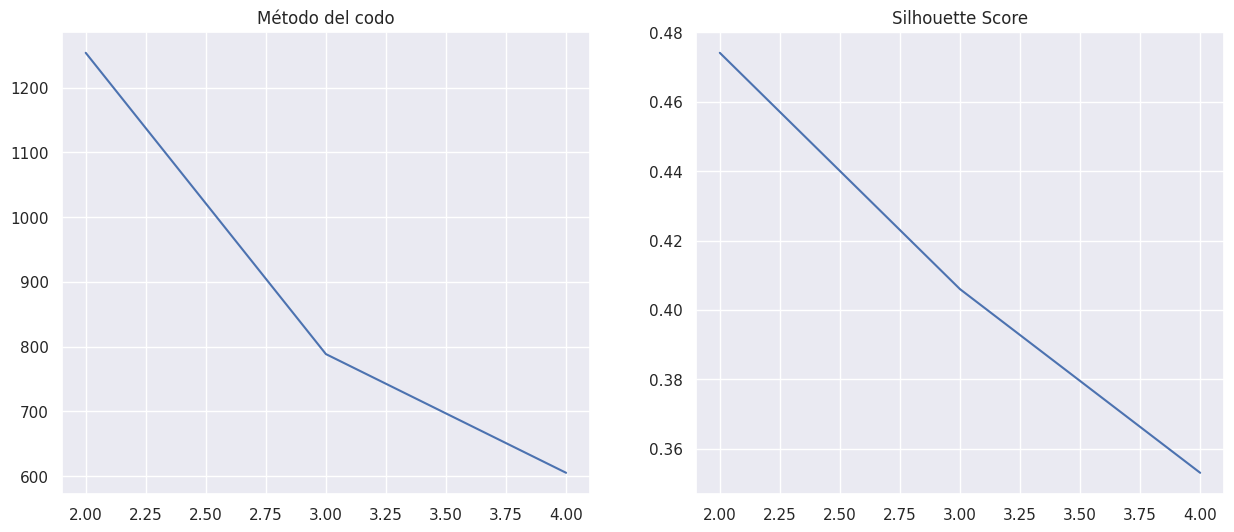

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Primera figura es el codo
axs[0].plot(grupos, wcss)
axs[0].set_title('Método del codo')

# La segunda es el Silhouette Score
axs[1].plot(grupos, sil_score)
axs[1].set_title('Silhouette Score')

In [20]:
# Haz un análisis por grupo para determinar las características que los hace 
# únicos. Ten en cuenta todas las variables numéricas.
model = KMeans(n_clusters=4, random_state=47)
clusters = model.fit_predict(X_norm)


df['Grupo'] = clusters.astype('str')
df.head()

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score,Grupo
0,female,group B,bachelor's degree,standard,none,72,72,74,1
1,female,group C,some college,standard,completed,69,90,88,2
2,female,group B,master's degree,standard,none,90,95,93,2
3,male,group A,associate's degree,free/reduced,none,47,57,44,0
4,male,group C,some college,standard,none,76,78,75,1


Text(0.5, 1.05, '4 grupos de alumnos')

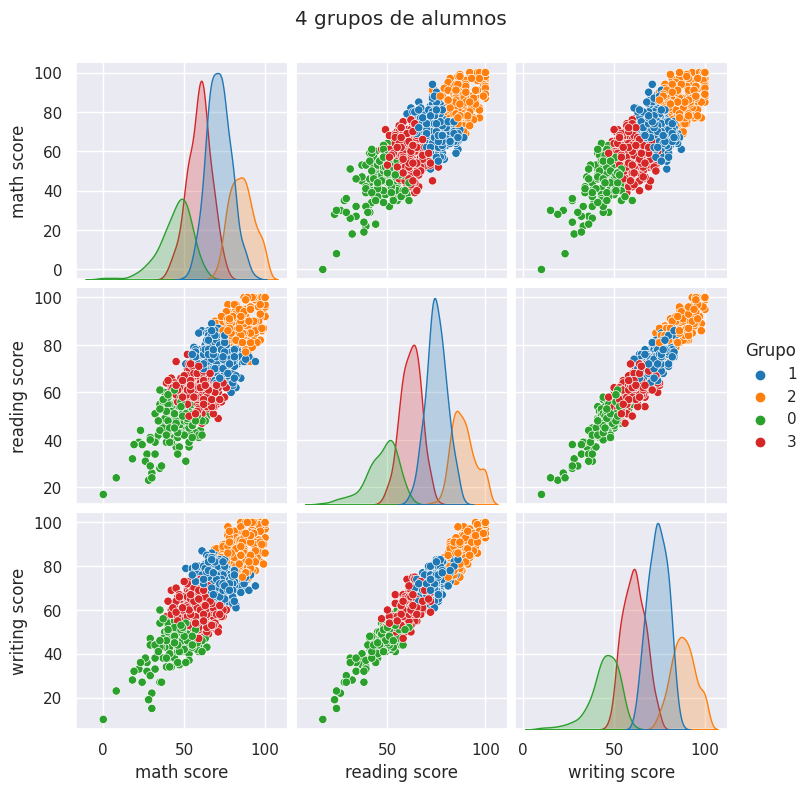

In [21]:

sns.pairplot(data=df, hue='Grupo', palette='tab10')
plt.suptitle('4 grupos de alumnos', y=1.05)

In [22]:
# Grafica los grupos con un pairplot y con un scatterplot en 3D 
# (si es necesario). Analiza las características de cada grupo.
# Creamos la figura donde graficaremos
fig = px.scatter_3d(df, x = 'writing score', y = 'reading score', 
                    z = 'math score', 
                    title='4 grupos de clientes',
                    color='Grupo',  
                    color_discrete_sequence=px.colors.qualitative.D3)

# mostramos la imagen
fig.show()

In [26]:
#Centros más cercanos
df.groupby('Grupo').mean()

,math score,reading score,writing score
Grupo,,,
0,44.503145,46.981132,44.566038
1,71.365169,74.938202,73.994382
2,85.489247,88.833333,88.193548
3,59.217391,61.866221,60.943144


In [27]:
df.groupby('Grupo').std()

,math score,reading score,writing score
Grupo,,,
0,10.251813,8.271096,8.279553
1,7.402803,5.218774,5.424511
2,7.313253,5.878883,6.517765
3,7.238708,5.209262,5.992174


Como podemos observar los mientras aumenta el nivel de grupo vemos que aumenta la calificación porque asi dividió el método, lo interesante es ver como los score en las pruebas son similares planteandonos preguntas como ¿Saber leer puede ayudarnos mucho en la prueba de mate? . Tmbién vemos en la desviación estandar que la mayor desviación esta en la calificación de mate y que el grupo 0 es quien tiene más datos extraños por su gran separación y si estos datos fueran reales me parecería interesante ver más información del grupo 0 y del grupo 2.